In [1]:
import csv
# import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D, ELU
from keras.layers.convolutional import Cropping2D
from keras import regularizers
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
def get_data(path):
    """
    Get data from a directory. Each directory has a 'driving_log.csv' file, and
    an 'IMG' folder.
    Input: path should have the slash in the end, e.g './data/'
    """
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    # read the csv file 
    images = []
    steering_angles = []
    for line in lines:
        img_center_path = line[0].split('/')[-1]
        img_left_path = line[1].split('/')[-1]
        img_right_path = line[2].split('/')[-1]
        current_path = path + 'IMG/'
        img_center = mpimg.imread(current_path + img_center_path)
        img_left = mpimg.imread(current_path + img_left_path)
        img_right = mpimg.imread(current_path + img_right_path)
        images.extend([img_center, img_left, img_right])
        # get steering data
        steering_center = float(line[3])
        # create adjusted steering measurements for the side camera images
        correction = 0.36 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction
        steering_angles.extend([steering_center, steering_left, steering_right])
    # convert to numpy array
    X = np.array(images)
    y = np.array(steering_angles)
    return X, y

In [3]:
# X_train1, y_train1 = get_data('./data-1/')
# X_train2, y_train2 = get_data('./data-2/')
# X_train3, y_train3 = get_data('./data-3/')
X_train4, y_train4 = get_data('./data-4/')
X_train5, y_train5 = get_data('./data-5/')
X_train6, y_train6 = get_data('./data/')
X_train7, y_train7 = get_data('./track2-1/')

In [4]:
# X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4, X_train5))
# y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5))
X_train = np.concatenate((X_train4, X_train5, X_train6, X_train7))
y_train = np.concatenate((y_train4, y_train5, y_train6, y_train7))

In [5]:
print(X_train.shape)
print(y_train.shape)

(89931, 160, 320, 3)
(89931,)


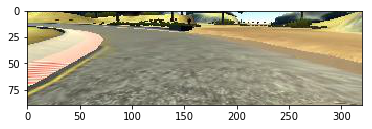

In [6]:
plt.imshow(X_train[10000][50:-20,:,:])
plt.show()

In [14]:
# create a simple model
input_shape = (160, 320, 3)
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
model.add(Cropping2D(cropping=((50,20),(0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, 
#                 W_regularizer=regularizers.l2(10e-3),
#                 b_regularizer=regularizers.l2(10e-3),
                activity_regularizer=None))
model.add(Dropout(0.2))
model.add(Dense(50,
#                 W_regularizer=regularizers.l2(10e-3),
#                 b_regularizer=regularizers.l2(10e-3),
                activity_regularizer=None))
model.add(Dropout(0.2))
model.add(Dense(10,
#                 W_regularizer=regularizers.l2(10e-3),
#                 b_regularizer=regularizers.l2(10e-3),
                activity_regularizer=None))
# model.add(Dropout(0.2))
model.add(Dense(1))

In [19]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2,
          shuffle=True, nb_epoch=1)

Train on 71944 samples, validate on 17987 samples
Epoch 1/1
71944/71944 [==============================] - 125s - loss: 0.0588 - val_loss: 0.2023


dict_keys(['val_loss', 'loss'])


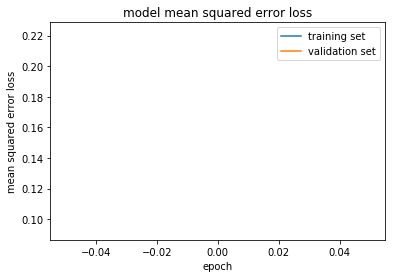

In [16]:
# print the output of model
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [17]:
model.save('model.h5')

In [ ]:
# Comma.AI model
# input_shape = (160, 320, 3)
# model = Sequential()
# model.add(Lambda(lambda x: x/127.5 - 1.,
#         input_shape=input_shape))
# model.add(Cropping2D(cropping=((50,20),(0,0))))
# model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
# model.add(ELU())
# model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
# model.add(ELU())
# model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
# model.add(Flatten())
# model.add(Dropout(.2))
# model.add(ELU())
# model.add(Dense(512))
# model.add(Dropout(.5))
# model.add(ELU())
# model.add(Dense(1))